In [38]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from functions import *
from NRG import * 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Single Impurity Anderson Model (SIAM)

### Parameters 

Hybridization function : $\Gamma (\omega) = {\Delta_0}\Theta(D-|\omega|)$    
Flat band approximation -> Density of state $\rho(\omega) = \frac{1}{2D}\Theta(D-|\omega|)$


In [39]:
Delta0 = 2.5e-4 # hybridization strength
D = 1 # half-bandwidth 
ozin = np.array([-1,1])*D 
RhoV2in = np.array([1,1]) * (Delta0) # hybridization function on the ozin grid 
Lambda = 2.5 # discretization parameter 
N = 55 # length of the Wilson chain 

In [40]:
ff, gg = do_cld(ozin, RhoV2in, Lambda, N)

### Sanity check
1. The first value of hopping terms ($t_0$) follows     
$t_0^2 = \int_{-dD}^{+D} d\omega \Gamma(\omega) = 2\Delta_0D$     
2. For large n, hopping terms should scale as $\Lambda^{-n/2}$

First condition satisfied? [ True]


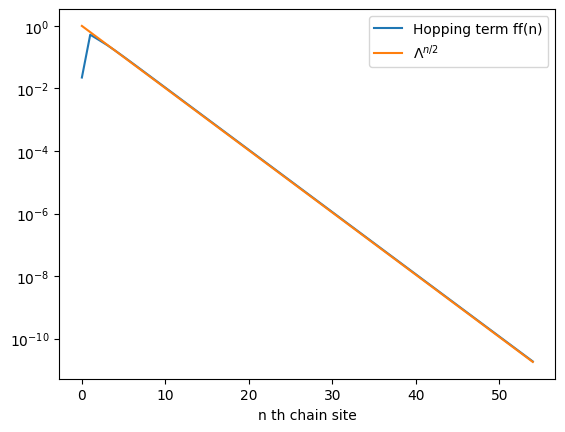

In [41]:
print('First condition satisfied?', np.abs(ff[0]**2-2*D*Delta0)<10**(-12))

plt.plot(ff, label= 'Hopping term ff(n)')
plt.plot(Lambda**(-np.arange(len(ff))/2), label = r'$\Lambda^{n/2}$')

plt.yscale('log')
plt.legend()
plt.xlabel('n th chain site')
plt.show() 

### Hamiltonain and Iterative diagonalization 

In [42]:

# Impurity Hamiltonian parameters
U = 4e-3
epsd = -U / 2.0

# Construct local operators: F (Annihilation), Z (Sign), S (Spin), I (Identity)
F, Z, S, I = get_local_space('FermionS')

# Local Annihilation and Creation Operators
F_up = F[:, :, 0]
F_down = F[:, :, 1]
Fc_up = np.conjugate(F[:, :, 0]).T # Creation operator $\text{Fc}_{\uparrow}$
Fc_down = np.conjugate(F[:, :, 1]).T # Creation operator $\text{Fc}_{\downarrow}$

NF = np.stack([Fc_up @ F_up, Fc_down @ F_down], axis=2) # Stacks N_up and N_down along the 3rd dimension (axis=2)

H0 = U * (NF[:, :, 0] @ NF[:, :, 1]) + epsd * (NF[:, :, 0] + NF[:, :, 1])
d = H0.shape[0]
A0 = np.eye(d).reshape(1, d, d) 

# NRG parameter
Nkeep = 300
N_tot_op = NF[:, :, 0] + NF[:, :, 1]


In [43]:

try:
    Inrg = nrg_iter_diag(H0, A0, Lambda, ff, F, gg, N_tot_op, Z, Nkeep)
    
    print("\n\n✅ NRG Iterative Diagonalization Complete!")
    print(f"Final EScale (Iteration {len(Inrg.EScale)-1}): {Inrg.EScale[-1]:.4e}")
    print(f"Final Ground State Energy E0: {Inrg.E0[-1]:.4e} (in units of EScale)")

except NameError:
    print("\nError: Ensure 'nrg_iter_diag' and all dependency functions (e.g., 'get_identity', 'contract', 'ff', 'gg') are defined.")
except Exception as e:
    print(f"\nAn error occurred during NRG diagonalization: {e}")

[2025-11-03T23:54:44] NRG: start
[2025-11-03T23:54:44] #00/55 : NK=4/4, EK=0/0
[2025-11-03T23:54:44] #01/55 : NK=16/16, EK=0.08641/0.08641
[2025-11-03T23:54:44] #02/55 : NK=64/64, EK=3.209/3.209
[2025-11-03T23:54:45] #03/55 : NK=256/256, EK=6.276/6.276
[2025-11-03T23:54:49] #04/55 : NK=328/1024, EK=5/13.02
[2025-11-03T23:54:56] #05/55 : NK=304/1312, EK=4.767/9.184
[2025-11-03T23:55:02] #06/55 : NK=328/1216, EK=5.011/10.58
[2025-11-03T23:55:08] #07/55 : NK=304/1312, EK=4.879/9.276
[2025-11-03T23:55:14] #08/55 : NK=328/1216, EK=5.044/10.64
[2025-11-03T23:55:20] #09/55 : NK=304/1312, EK=5.071/9.418
[2025-11-03T23:55:25] #10/55 : NK=328/1216, EK=5.116/10.79
[2025-11-03T23:55:32] #11/55 : NK=320/1312, EK=5.538/9.698
[2025-11-03T23:55:38] #12/55 : NK=328/1280, EK=5.252/11.12
[2025-11-03T23:55:44] #13/55 : NK=316/1312, EK=5.704/10.23
[2025-11-03T23:55:50] #14/55 : NK=328/1264, EK=5.718/11.5
[2025-11-03T23:55:57] #15/55 : NK=328/1312, EK=6.106/11.17
[2025-11-03T23:56:03] #16/55 : NK=322/1312, 

## Energy flow diagrams

In [7]:
Eshow = 3.0

# --- Process Even Iterations (Index 0, 2, 4, ...) ---

Eeven_list = [E[E <= Eshow] for i, E in enumerate(Inrg.EK) if i % 2 == 0]
maxEeven = 0
if Eeven_list:
    maxEeven = max(len(E) for E in Eeven_list)

Eeven_padded = []
for E in Eeven_list:
    padding_size = maxEeven - len(E)
    padded_E = np.pad(E, (0, padding_size), 'constant', constant_values=np.nan)
    Eeven_padded.append(padded_E)

if Eeven_padded:
    Eeven = np.stack(Eeven_padded, axis=1)
else:
    Eeven = np.array([[]]).T
    
x_even = np.arange(0, len(Inrg.EK), 2)


# --- Process Odd Iterations (Index 1, 3, 5, ...) ---
Eodd_list = [E[E <= Eshow] for i, E in enumerate(Inrg.EK) if i % 2 != 0]
maxEodd = 0
if Eodd_list:
    maxEodd = max(len(E) for E in Eodd_list)

Eodd_padded = []
for E in Eodd_list:
    padding_size = maxEodd - len(E)
    padded_E = np.pad(E, (0, padding_size), 'constant', constant_values=np.nan)
    Eodd_padded.append(padded_E)
if Eodd_padded:
    Eodd = np.stack(Eodd_padded, axis=1)
else:
    Eodd = np.array([[]]).T

x_odd = np.arange(1, len(Inrg.EK), 2)



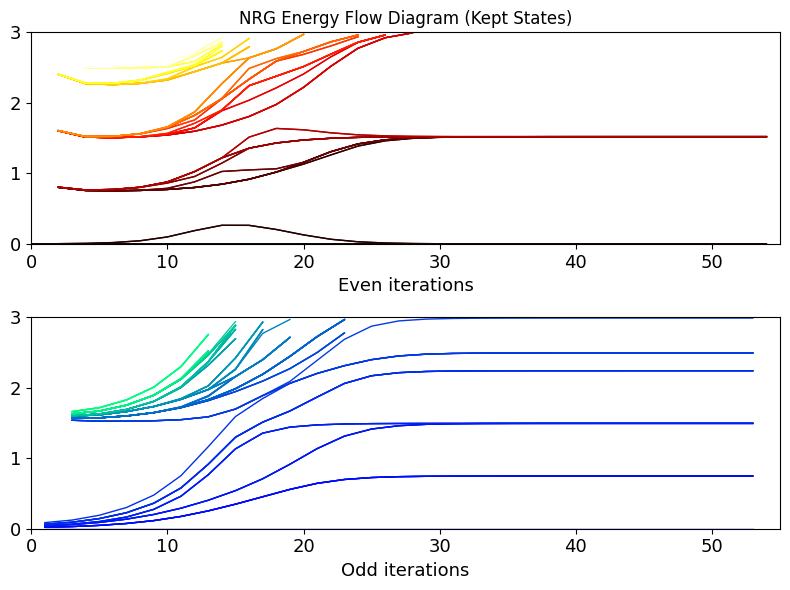

In [8]:
# --- Plotting ---
plt.figure(figsize=(8, 6))

# Upper panel (Even iterations)
plt.subplot(2, 1, 1)
# Plotting the matrix Eeven against the iteration indices x_even.
# Since Eeven has iterations as columns, Matplotlib plots each row as a separate line,
# resulting in vertical lines of energy levels at each iteration.
num = len(Eeven)
cmap = cm.get_cmap('hot')
colors_even = cmap(np.linspace(0, 1, num))
for i in range(num):
    plt.plot(x_even, Eeven[i, :], linewidth=1.0,color=colors_even[i])
plt.xlabel('Even iterations', fontsize=13)
plt.xlim([0, len(Inrg.EK) - 1])
plt.ylim([0, Eshow])
plt.tick_params(labelsize=13)
plt.title('NRG Energy Flow Diagram (Kept States)')

# Lower panel (Odd iterations)
plt.subplot(2, 1, 2)
num = len(Eodd)
cmap = cm.get_cmap('winter')
colors_odd = cmap(np.linspace(0, 1, num))
for i in range(num):
    plt.plot(x_odd, Eodd[i, :], linewidth=1.0,color=colors_odd[i])

plt.xlabel('Odd iterations', fontsize=13)
plt.xlim([0, len(Inrg.EK) - 1])
plt.ylim([0, Eshow])
plt.tick_params(labelsize=13)

# Save the figure
plt.tight_layout()


## Kondo Model (single impurity)

$J = 2(\frac{2}{U} + \frac{2}{U}) |V|^2 = 8\frac{\Delta_0}{\pi U} \cdot2D$ 

In [9]:

J = 8 * Delta0 /np.pi/ U*2*D # Kondo coupling strength

ozin = np.array([-1.0, 1.0]) * D
RhoV2in = np.array([1.0, 1.0]) 

# NRG parameters
Lambda = 2.5
N = 55
Nkeep = 300

ff, gg = do_cld(ozin, RhoV2in, Lambda, N)

# # Construct local operators
F, Z, S, I = get_local_space('FermionS')
Ss, Is = get_local_space('Spin', 1/2)

# Particle number operator (NF is rank-3: D_phys x D_phys x 2 (spin index))
F_up = F[:, :, 0]
F_down = F[:, :, 1]
Fc_up = np.conjugate(F_up).T
Fc_down = np.conjugate(F_down).T

N_up = Fc_up @ F_up
N_down = Fc_down @ F_down
NF = np.stack([N_up, N_down], axis=2)

N_tot_op = NF[:, :, 0] + NF[:, :, 1] # Total number operator for on-site term
A0 = get_identity(Is, 1, I, 1, [0, 2, 1])

H0_kondo_base = update_left(Ss, 3, A0, np.transpose(S.conj(), (1, 0, 2)), 3, A0)

H0_kondo = H0_kondo_base * J
H0_on_site = gg[0] * update_left(None, None, A0, N_tot_op, 2, A0) 

H0 = H0_kondo + H0_on_site

print(f"Impurity Hamiltonian H0 constructed successfully.")
print(f"H0 shape: {H0.shape}")
print(f"Kondo coupling J: {J:.4e}")
print(f"First bath site energy gg[0]: {gg[0][0]:.4e}")


Impurity Hamiltonian H0 constructed successfully.
H0 shape: (8, 8)
Kondo coupling J: 3.1831e-01
First bath site energy gg[0]: 1.1505e-17


In [10]:
Inrg = nrg_iter_diag(H0, A0, Lambda, ff[1:], F, gg[1:], N_tot_op, Z, Nkeep)
    

[2025-11-03T19:57:45] NRG: start
[2025-11-03T19:57:45] #00/54 : NK=8/8, EK=0.07958/0.07958
[2025-11-03T19:57:45] #01/54 : NK=32/32, EK=3.231/3.231
[2025-11-03T19:57:45] #02/54 : NK=128/128, EK=6.466/6.466
[2025-11-03T19:57:46] #03/54 : NK=306/512, EK=7.162/13.1
[2025-11-03T19:57:50] #04/54 : NK=328/1224, EK=6.853/13
[2025-11-03T19:57:56] #05/54 : NK=316/1312, EK=6.891/13.64
[2025-11-03T19:58:02] #06/54 : NK=328/1264, EK=6.819/12.8
[2025-11-03T19:58:08] #07/54 : NK=310/1312, EK=6.814/13.54
[2025-11-03T19:58:14] #08/54 : NK=328/1240, EK=6.84/12.77
[2025-11-03T19:58:19] #09/54 : NK=314/1312, EK=6.89/13.46
[2025-11-03T19:58:24] #10/54 : NK=328/1256, EK=6.911/12.88
[2025-11-03T19:58:30] #11/54 : NK=322/1312, EK=7.007/13.42
[2025-11-03T19:58:36] #12/54 : NK=317/1288, EK=6.912/13.18
[2025-11-03T19:58:41] #13/54 : NK=314/1268, EK=7.134/13.16
[2025-11-03T19:58:45] #14/54 : NK=302/1256, EK=7.146/13.41
[2025-11-03T19:58:50] #15/54 : NK=312/1208, EK=7.324/13.32
[2025-11-03T19:58:55] #16/54 : NK=31

### Energy flow diagram

In [11]:
Eshow = 3.0

# --- Process Even Iterations (Index 0, 2, 4, ...) ---

Eeven_list = [E[E <= Eshow] for i, E in enumerate(Inrg.EK) if i % 2 == 0]
maxEeven = 0
if Eeven_list:
    maxEeven = max(len(E) for E in Eeven_list)

Eeven_padded = []
for E in Eeven_list:
    padding_size = maxEeven - len(E)
    padded_E = np.pad(E, (0, padding_size), 'constant', constant_values=np.nan)
    Eeven_padded.append(padded_E)

if Eeven_padded:
    Eeven = np.stack(Eeven_padded, axis=1)
else:
    Eeven = np.array([[]]).T
    
x_even = np.arange(0, len(Inrg.EK), 2)


# --- Process Odd Iterations (Index 1, 3, 5, ...) ---
Eodd_list = [E[E <= Eshow] for i, E in enumerate(Inrg.EK) if i % 2 != 0]
maxEodd = 0
if Eodd_list:
    maxEodd = max(len(E) for E in Eodd_list)

Eodd_padded = []
for E in Eodd_list:
    padding_size = maxEodd - len(E)
    padded_E = np.pad(E, (0, padding_size), 'constant', constant_values=np.nan)
    Eodd_padded.append(padded_E)
if Eodd_padded:
    Eodd = np.stack(Eodd_padded, axis=1)
else:
    Eodd = np.array([[]]).T

x_odd = np.arange(1, len(Inrg.EK), 2)



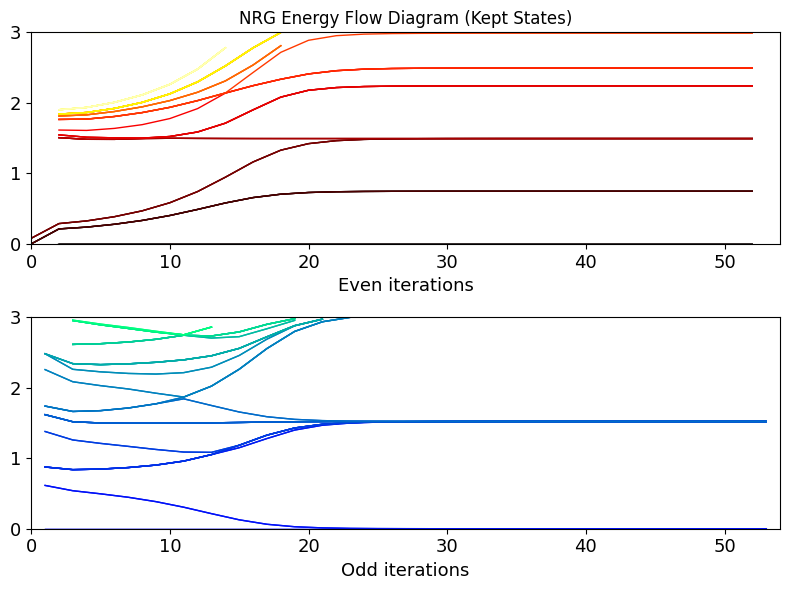

In [12]:

plt.figure(figsize=(8, 6))

# Upper panel (Even iterations)
plt.subplot(2, 1, 1)
# Plotting the matrix Eeven against the iteration indices x_even.
# Since Eeven has iterations as columns, Matplotlib plots each row as a separate line,
# resulting in vertical lines of energy levels at each iteration.
num = len(Eeven)
cmap = cm.get_cmap('hot')
colors_even = cmap(np.linspace(0, 1, num))
for i in range(num):
    plt.plot(x_even, Eeven[i, :], linewidth=1.0,color=colors_even[i])
plt.xlabel('Even iterations', fontsize=13)
plt.xlim([0, len(Inrg.EK) - 1])
plt.ylim([0, Eshow])
plt.tick_params(labelsize=13)
plt.title('NRG Energy Flow Diagram (Kept States)')

# Lower panel (Odd iterations)
plt.subplot(2, 1, 2)
num = len(Eodd)
cmap = cm.get_cmap('winter')
colors_odd = cmap(np.linspace(0, 1, num))
for i in range(num):
    plt.plot(x_odd, Eodd[i, :], linewidth=1.0,color=colors_odd[i])

plt.xlabel('Odd iterations', fontsize=13)
plt.xlim([0, len(Inrg.EK) - 1])
plt.ylim([0, Eshow])
plt.tick_params(labelsize=13)

# Save the figure
plt.tight_layout()

